In [421]:
##### POC Bundesbank API
## Tools:
# https://api.statistiken.bundesbank.de/doc/index.html?urls.primaryName=Deutsche%20REST%20API%20Dokumentation
# https://curlconverter.com/

In [441]:
##### imports
import requests
import statsmodels.api as sm
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
scaler = MinMaxScaler()

In [423]:
##### API CAll from KEY

def extract_api_call(sample_key):
    # Split key by "."
    key_list = sample_key.split(".")
    # Extract FlowRef
    flowRef = key_list[0]
    # Extract key 
    key = sample_key[len(key_list[0])+1:]
    # Build call string
    # API Part of URL
    api_part_generic = "https://api.statistiken.bundesbank.de/rest/data/"
    api_part_specific = flowRef+"/"+key
    api_call = api_part_generic + api_part_specific
    return api_call

In [424]:
##### Function that takes in the api-call and performs a request and stores the data in a response_json

def auto_response_saver(api_call):
    #Define the header
    headers = {'accept': 'application/vnd.sdmx.data+json;version=1.0.0',}
    # Define parameters
    params = {'detail': 'full',}
    # Define full-sub
    full_response = '?detail=full'
    # Create full call
    full_call = api_call + full_response
    # Get the actual response
    response = requests.get(full_call, params=params, headers=headers,)
    # As json
    response_list = response.json()
    return(response_list)

In [425]:
##### Take Response and return DF

def extract_response(Response, ColName):
    Response_Numbers = []
    VarKey = list(Response["data"]["dataSets"][0]["series"].keys())[0]

    for key in Response["data"]["dataSets"][0]["series"][VarKey]["observations"]:
        Response_Numbers.append(Response["data"]["dataSets"][0]["series"][VarKey]["observations"][key][0])

    Response_Numbers_PD = pd.DataFrame(Response_Numbers, columns = [ColName])    

    # General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
    Response_Timestamp = []

    for element in Response["data"]["structure"]["dimensions"]["observation"][0]["values"]:
        Response_Timestamp.append(element["id"])

    Response_Timestamp_PD = pd.DataFrame(Response_Timestamp, columns = ["time"])

    Response_DF = pd.concat([Response_Timestamp_PD,Response_Numbers_PD],axis=1).set_index("time")
    
    return Response_DF

In [426]:
##### Create a function, that takes in a KEY and a "Name" that then builds the api call, fetches the data, extracts the data from the response and returns dataframes

def BBK2PD(KEY, ColName):
    Output = extract_response(auto_response_saver(extract_api_call(KEY)), ColName)
    return Output

In [427]:
def plot_acf_pacf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax2)

In [428]:
#####Variable Declaration

Gold = "BBEX3.M.XAU.EUR.EA.AC.C06"
ALQ = "BBDL1.M.DE.Y.UNE.UBA000.A0000.A01.D00.0.R00.A"
Zinsentwicklung = "BBK01.SUD189"
Realzinssätze_Banken = "BBK01.SUR106"
EZB_Einlagenfazilität = "BBK01.SU0200"
HVPI ="BBDP1.M.DE.N.HVPI.C.A00000.I15.A"
Effektivzinsen = "BBK01.SUD131Z"

### Create a from Variables
Keys_All = {}
for i in ("Gold", "ALQ", "Zinsentwicklung", "Realzinssätze_Banken", "EZB_Einlagenfazilität", "HVPI", "Effektivzinsen"):
    Keys_All[i] = locals()[i]
    
### List
Keys_All_List = list(Keys_All.items())

### Pandas DF
Keys_All_pd = pd.DataFrame(data=Keys_All_List, columns = ["Variable","KEY"])

In [429]:
### Loop throught the whole thing and get the DFs.

for element in Keys_All_List:
    exec(f"{element[0]} = BBK2PD(element[1], element[0])")

In [430]:
Dataframe = pd.concat([Gold, ALQ, Zinsentwicklung ,Realzinssätze_Banken, EZB_Einlagenfazilität, HVPI, Effektivzinsen], axis=1, join='inner')
Dataframe_Diffed = Dataframe.diff(periods=1, axis=0)[1:]

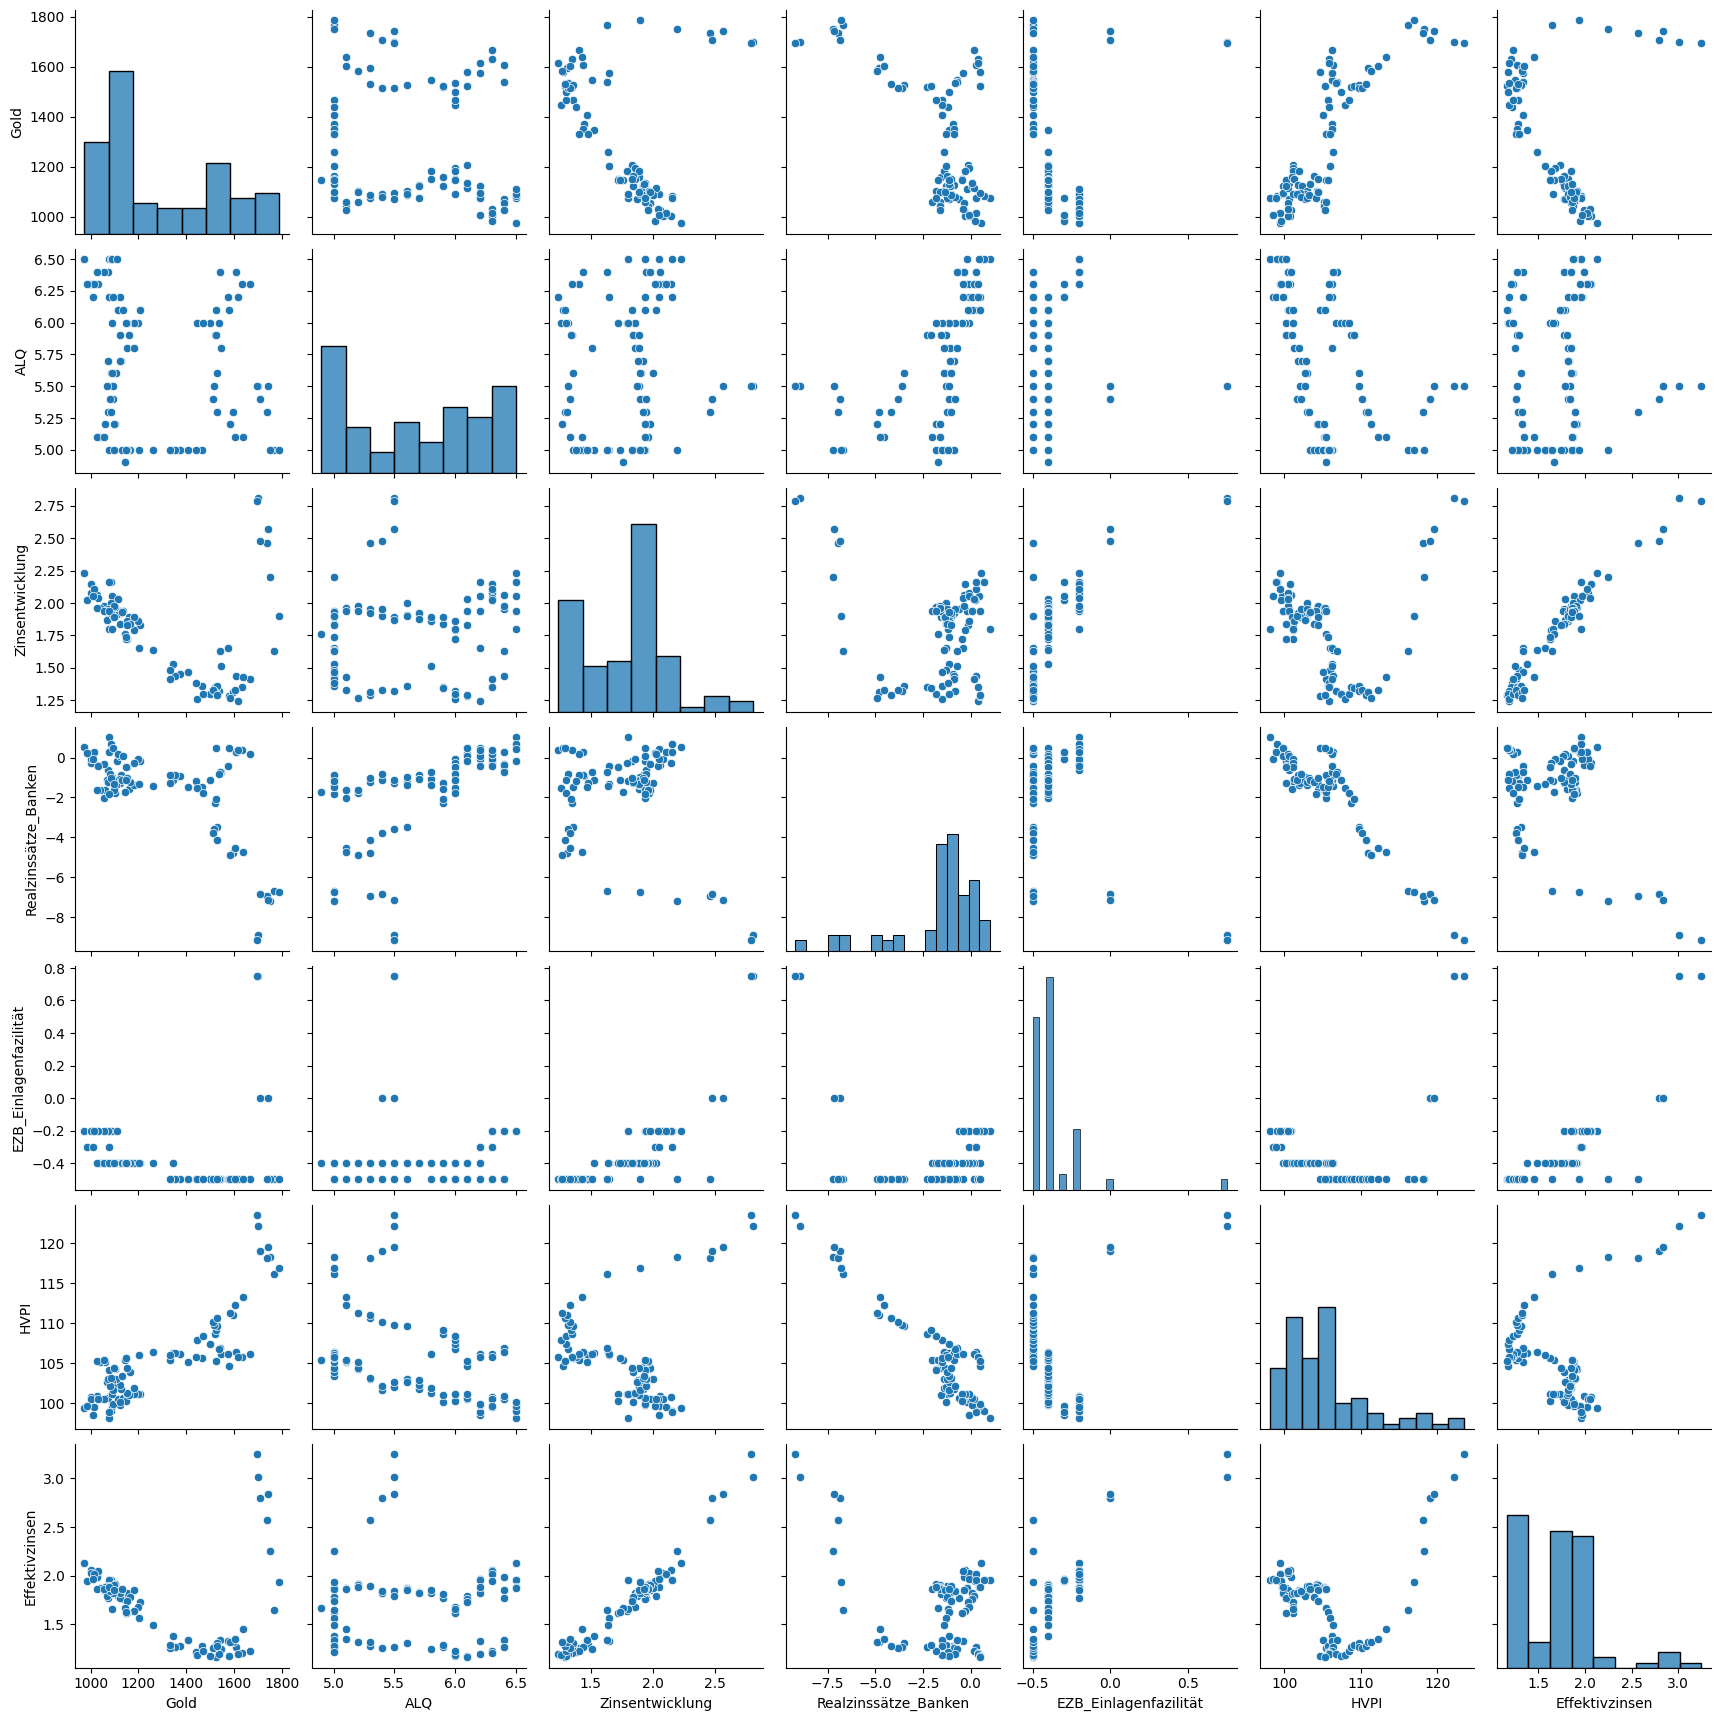

In [431]:
sns.pairplot(Dataframe)

<AxesSubplot: >

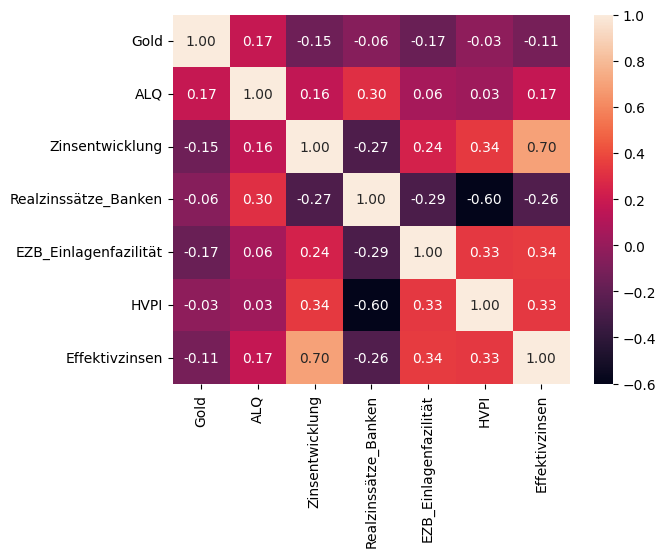

In [432]:
sns.heatmap(Dataframe_Diffed.corr(), annot = True, fmt='.2f')

In [439]:
Dataframe.describe()

,Gold,ALQ,Zinsentwicklung,Realzinssätze_Banken,EZB_Einlagenfazilität,HVPI,Effektivzinsen
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,1286.750358,5.664211,1.784000,-1.618737,-0.374737,105.287368,1.709895
std,244.505900,0.521233,0.343701,2.170011,0.199850,5.437209,0.406245
min,973.529000,4.900000,1.240000,-9.180000,-0.500000,98.100000,1.160000
25%,1088.207000,5.100000,1.445000,-1.615000,-0.500000,101.150000,1.320000
50%,1152.173000,5.600000,1.870000,-1.120000,-0.400000,104.400000,1.790000
75%,1523.592500,6.100000,1.955000,-0.310000,-0.400000,106.400000,1.880000
max,1787.106000,6.500000,2.810000,1.030000,0.750000,123.500000,3.250000


In [437]:
Dataframe["HVPI"]

time
2014-12     99.4
2015-01     98.1
2015-02     99.0
2015-03     99.7
2015-04    100.2
           ...  
2022-06    118.1
2022-07    119.0
2022-08    119.5
2022-09    122.1
2022-10    123.5
Name: HVPI, Length: 95, dtype: float64

In [448]:
x = Dataframe[["Gold","ALQ"]]
y = Dataframe["HVPI"]
 
x = sm.add_constant(x) # adding a constant
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   HVPI   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     186.0
Date:                Tue, 27 Dec 2022   Prob (F-statistic):           4.76e-33
Time:                        21:39:34   Log-Likelihood:                -218.31
No. Observations:                  95   AIC:                             442.6
Df Residuals:                      92   BIC:                             450.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        101.7595      3.348     30.396      0.0

time
2014-12     97.107812
2015-01     98.871789
2015-02     99.013404
2015-03     99.119482
2015-04     99.502392
              ...    
2022-06    114.281912
2022-07    113.433090
2022-08    113.695403
2022-09    112.992098
2022-10    112.877996
Length: 95, dtype: float64

In [238]:
##### Rough Method, without loop

#Response_Gold = auto_response_saver(extract_api_call(Keys_All_List[0][1]))
#Response_ALQ = auto_response_saver(extract_api_call(Keys_All_List[1][1]))
#Response_Zinsentwicklung = auto_response_saver(extract_api_call(Keys_All_List[2][1]))
#Response_Realzinssätze_Banken = auto_response_saver(extract_api_call(Keys_All_List[3][1]))
#Response_EZB_Einlagenfazilität = auto_response_saver(extract_api_call(Keys_All_List[4][1]))
#Response_HVPI = auto_response_saver(extract_api_call(Keys_All_List[5][1]))
#Response_Effektivzinsen = auto_response_saver(extract_api_call(Keys_All_List[6][1]))

In [149]:
### (0) Gold

# General Data["data"]["dataSets"][0]["series"]
# list(Response_HVPI["data"]["dataSets"][0]["series"].keys())[0]

Gold_Numbers = []

for key in Response_Gold["data"]["dataSets"][0]["series"]['0:0:0:0:0:0']["observations"]:
    Gold_Numbers.append(Response_Gold["data"]["dataSets"][0]["series"]['0:0:0:0:0:0']["observations"][key][0])

    Gold_Numbers_PD = pd.DataFrame(Gold_Numbers, columns = ["Goldpreis"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
Gold_Timestamp = []

for element in Response_Gold["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    Gold_Timestamp.append(element["id"])

    Gold_Timestamp_PD = pd.DataFrame(Gold_Timestamp, columns = ["time"])

Gold_DF = pd.concat([Gold_Timestamp_PD,Gold_Numbers_PD],axis=1).set_index("time")

In [150]:
### (I) ALQ

# General Data["data"]["dataSets"][0]["series"]

ALQ_Numbers = []

for key in Response_ALQ["data"]["dataSets"][0]["series"]['0:0:0:0:0:0:0:0:0:0:0']["observations"]:
    ALQ_Numbers.append(Response_ALQ["data"]["dataSets"][0]["series"]['0:0:0:0:0:0:0:0:0:0:0']["observations"][key][0])

    ALQ_Numbers_PD = pd.DataFrame(ALQ_Numbers, columns = ["Arbeitslosenquote"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
ALQ_Timestamp = []

for element in Response_ALQ["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    ALQ_Timestamp.append(element["id"])

    ALQ_Timestamp_PD = pd.DataFrame(ALQ_Timestamp, columns = ["time"])

ALQ_DF = pd.concat([ALQ_Timestamp_PD,ALQ_Numbers_PD],axis=1).set_index("time")

In [151]:
### (II)  Zinsentwicklung

# General Data["data"]["dataSets"][0]["series"]

Zinsentwicklung_Numbers = []

for key in Response_Zinsentwicklung["data"]["dataSets"][0]["series"]["0"]["observations"]:
    Zinsentwicklung_Numbers.append(Response_Zinsentwicklung["data"]["dataSets"][0]["series"]["0"]["observations"][key][0])
Zinsentwicklung_Numbers_PD = pd.DataFrame(Zinsentwicklung_Numbers, columns = ["EZB Zinsentwicklung"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
Zinsentwicklung_Timestamp = []

for element in Response_Zinsentwicklung["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    Zinsentwicklung_Timestamp.append(element["id"])
Zinsentwicklung_Timestamp_PD = pd.DataFrame(Zinsentwicklung_Timestamp, columns = ["time"])

Zinsentwicklung_DF = pd.concat([Zinsentwicklung_Timestamp_PD,Zinsentwicklung_Numbers_PD],axis=1).set_index("time")

In [152]:
### (III) Realzinssätze_Banken

# General Data["data"]["dataSets"][0]["series"]

Realzinssätze_Banken_Numbers = []

for key in Response_Realzinssätze_Banken["data"]["dataSets"][0]["series"]['0']["observations"]:
    Realzinssätze_Banken_Numbers.append(Response_Realzinssätze_Banken["data"]["dataSets"][0]["series"]['0']["observations"][key][0])

    Realzinssätze_Banken_Numbers_PD = pd.DataFrame(Realzinssätze_Banken_Numbers, columns = ["Realzinsen"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
Realzinssätze_Banken_Timestamp = []

for element in Response_Realzinssätze_Banken["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    Realzinssätze_Banken_Timestamp.append(element["id"])

Realzinssätze_Banken_Timestamp_PD = pd.DataFrame(Realzinssätze_Banken_Timestamp, columns = ["time"])
Realzinssätze_Banken_DF = pd.concat([Realzinssätze_Banken_Timestamp_PD,Realzinssätze_Banken_Numbers_PD],axis=1).set_index("time")

In [153]:
### (IV) EZB Einlagenfazilität

# General Data["data"]["dataSets"][0]["series"]

EZB_Einlagenfazilität_Numbers = []

for key in Response_EZB_Einlagenfazilität["data"]["dataSets"][0]["series"]["0"]["observations"]:
    EZB_Einlagenfazilität_Numbers.append(Response_EZB_Einlagenfazilität["data"]["dataSets"][0]["series"]["0"]["observations"][key][0])
EZB_Einlagenfazilität_Numbers_PD = pd.DataFrame(EZB_Einlagenfazilität_Numbers, columns = ["EZB Einlagenfazilität"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
EZB_Einlagenfazilität_Timestamp = []

for element in Response_EZB_Einlagenfazilität["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    EZB_Einlagenfazilität_Timestamp.append(element["id"])
EZB_Einlagenfazilität_Timestamp_PD = pd.DataFrame(EZB_Einlagenfazilität_Timestamp, columns = ["time"])

EZB_Einlagenfazilität_DF = pd.concat([EZB_Einlagenfazilität_Timestamp_PD,EZB_Einlagenfazilität_Numbers_PD],axis=1).set_index("time")

In [154]:
### (V) HVPI

# General Data["data"]["dataSets"][0]["series"]

HVPI_Numbers = []

for key in Response_HVPI["data"]["dataSets"][0]["series"]['0:0:0:0:0:0:0:0']["observations"]:
    HVPI_Numbers.append(Response_HVPI["data"]["dataSets"][0]["series"]['0:0:0:0:0:0:0:0']["observations"][key][0])

    HVPI_Numbers_PD = pd.DataFrame(HVPI_Numbers, columns = ["HVPI DEU"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
HVPI_Timestamp = []

for element in Response_HVPI["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    HVPI_Timestamp.append(element["id"])

    HVPI_Timestamp_PD = pd.DataFrame(HVPI_Timestamp, columns = ["time"])

HVPI_DF = pd.concat([HVPI_Timestamp_PD,HVPI_Numbers_PD],axis=1).set_index("time")

In [271]:
### (VI) Effektivzinsen

# General Data["data"]["dataSets"][0]["series"]

Effektivzinsen_Numbers = []

for key in Response_Effektivzinsen["data"]["dataSets"][0]["series"]["0"]["observations"]:
    Effektivzinsen_Numbers.append(Response_Effektivzinsen["data"]["dataSets"][0]["series"]["0"]["observations"][key][0])
Effektivzinsen_Numbers_PD = pd.DataFrame(Effektivzinsen_Numbers, columns = ["Effektivzinsen"])    

# General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
Effektivzinsen_Timestamp = []

for element in Response_Effektivzinsen["data"]["structure"]["dimensions"]["observation"][0]["values"]:
    Effektivzinsen_Timestamp.append(element["id"])
Effektivzinsen_Timestamp_PD = pd.DataFrame(Effektivzinsen_Timestamp, columns = ["time"])

Effektivzinsen_DF = pd.concat([Effektivzinsen_Timestamp_PD,Effektivzinsen_Numbers_PD],axis=1).set_index("time")

In [418]:
%reset -f